In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import torch.optim as optim
import tqdm as tq

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [39]:
n=50
training_examples=50000
cv_examples=5000
testing_examples=5000

class Net_NHL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,1)
  
  def forward(self, X):
    return self.fc(X)

class Net_1HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=self.fc1(Op_1)
    return Op_2

class Net_2HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,n//4)
    self.fc2=nn.Linear(n//4,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=F.relu(self.fc1(Op_1))
    Op_3=self.fc2(Op_2)
    return Op_3


In [40]:
def generate_dataset(examples,n,_type):
  if(_type=='uniform'):
    train = np.random.rand(examples,n)
  elif(_type=='normal'):
    train = np.random.normal(loc=0,scale=1,size=(examples,n))
  elif(_type=='exponential'):
    train=np.random.exponential(scale=np.random.randint(1,5),size=(examples,n))
  
  train.sort()
  search = np.random.randint(0,n,examples)
  val = train[np.arange(len(train)), search]
  final_train= np.c_[train,val]
  final_train=final_train.astype("float32")
  mini=np.amin(final_train,axis = 1).reshape(examples,1)
  maxi=np.amax(final_train,axis = 1).reshape(examples,1)
  final_train=(final_train-mini)/(maxi-mini)

  final_train_ans=search/n
  final_train_ans=final_train_ans.astype("float32")

  train_input= torch.from_numpy(final_train)
  train_ans = torch.from_numpy(final_train_ans)
  train_input = train_input.to('cuda')
  train_ans = train_ans.to('cuda')


  return train_input,train_ans

def train_dataset(net,train_input,train_ans,cv_input,cv_ans,examples,lr=1e-2,batch_size=5000,epochs=1000):
  optimizer = optim.Adam(net.parameters(),lr =lr)
  train_loss = []
  cv_loss = []

  for e in tq.tqdm(range(epochs)):
    epoch_loss = 0
    for b in range(int(examples/batch_size)):
      
      x = train_input[b*batch_size:(b+1)*batch_size]
      y = train_ans[b*batch_size:(b+1)*batch_size]
      out = net(x.view(-1,n+1))
      loss= F.mse_loss(out.view(-1),y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    epoch_loss = epoch_loss/int(examples/batch_size)
    train_loss.append(epoch_loss)  
    print(epoch_loss)

    out = net(cv_input.view(-1,n+1))
    loss= F.mse_loss(out.view(-1),cv_ans)
    cv_loss.append(loss.item())

  plt.plot(np.arange(epochs),train_loss,label = 'Train')
  plt.plot(np.arange(epochs),cv_loss,label = 'Cross Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Average Epoch MSE Loss')
  plt.legend()
  plt.title('Loss vs Epochs')
  plt.show()


In [41]:
def binary_search(arr, l, r,x,cnt=0):
  # arr = list(arr)
  if r >= l:
        mid = l + int(np.floor((r - l)/ 2))
        if arr[mid] == x:
            return mid,cnt+1
        elif arr[mid] > x:
            return binary_search(arr, l, mid-1, x,cnt+1)
        else:
            return binary_search(arr, mid + 1, r, x,cnt+1)
  else:
        return r,cnt

def predict(net,test_input,n):
  out=net(test_input.view(-1,n+1))
  out=out*n
  return out

def get_predictions(test_input,n,examples,out):
  predictions_cnt = []
  bs_cnt = []
  for i in range(examples):
    bs_cnt.append(binary_search(test_input[i],0,n-1,test_input[i][n])[1])
    idx = int(out[i]) #predicted index
    if(idx>=n):
      idx = n-1
    if(idx<0):
      idx = 0
    
    if(test_input[i][idx] > test_input[i][n]):
      sub = 2
      cnt = 1
      while idx-sub >= 0:
        cnt+=1
        if(test_input[i][idx-sub] < test_input[i][n]):
          break;
        sub*= 2
      left = max(idx-sub,0)
      right = idx-(sub//2)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
      
    elif (test_input[i][idx] < test_input[i][n]):
      sub = 2
      cnt = 1
      while idx+sub <= n-1:
        cnt+=1
        if(test_input[i][idx+sub] > test_input[i][n]):
          break;
        sub*= 2
      left = idx+(sub//2)
      right = min(idx+sub,n-1)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
    else:
      predictions_cnt.append(1)
    
  return predictions_cnt,bs_cnt

In [42]:
def test_single_array(net,n,_type):
  np.random.seed(64)
  if(_type=='normal'):
    testing = np.random.normal(loc=0,scale=1,size=n)
  elif(_type=='uniform'):
    testing = np.random.rand(n)
  elif(_type=='exponential'):
    testing=np.random.exponential(scale=np.random.randint(1,5),size=n)

  testing.sort()
  testing=(testing-testing[0])/(testing[n-1]-testing[0])
  
  L=[]
  for i in range(n):
    test_val = testing[i]
    test = np.append(testing,test_val)
    test = test.astype('float32')
    test_input = torch.from_numpy(test)
    test_input = test_input.to("cuda")
    out = net(test_input.view(-1, n+1))
    L.append(out.item()*n)
  
  plt.scatter(np.arange(n),testing)
  plt.title('Test Array')
  plt.xlabel('Index')
  plt.ylabel('Test Array Value')
  plt.show()
  plt.scatter(np.arange(n),L)
  plt.title('Predicted Index for each element')
  plt.xlabel('Index')
  plt.ylabel('Predicted Index')
  plt.show()
    

In [43]:
def generate_plots(predictions_cnt,bs_cnt):
  unique1, counts1 = np.unique(predictions_cnt, return_counts=True)
  d1  = dict(zip(unique1, counts1))
  unique2, counts2 = np.unique(bs_cnt, return_counts=True)
  d2  = dict(zip(unique2, counts2))
  plt.plot(list(d1.keys()),list(d1.values()),label = 'Predictor')
  plt.plot(list(d2.keys()),list(d2.values()),label = 'Binary Search')
  plt.xlabel('Number of Array Lookups(Steps)')
  plt.ylabel('Count of Test Inputs')
  plt.legend()
  plt.show()

  return d1,d2

def average_steps(d1,d2):
  print('Average Number of Steps')
  s=0
  for i in d1:
    s+=d1[i]*i
  print('Through Predictor:'+str(s/testing_examples))
  s=0
  for i in d2:
    s+=d2[i]*i
  print('Through Binary Search:'+str(s/testing_examples))


#Uniform


 60%|██████    | 18/30 [00:00<00:00, 87.62it/s]

0.110938560962677
0.08370920419692993
0.0681281965225935
0.05553385801613331
0.044778167828917505
0.03575572520494461
0.028283958695828913
0.022175840847194195
0.01726223398000002
0.013373014889657498
0.01034189686179161
0.0080200070515275
0.006269238935783505
0.0049708901904523374
0.004023904097266495
0.003344547818414867
0.0028647898696362974
0.0025307433214038612


100%|██████████| 30/30 [00:00<00:00, 87.18it/s]


0.0023012007819488644
0.0021449517691507934
0.002039216400589794
0.0019676017458550633
0.0019186578691005706
0.0018845217418856919
0.0018599481321871282
0.00184148425469175
0.0018269289867021143
0.0018148923525586724
0.0018045201082713901
0.0017952951486222446


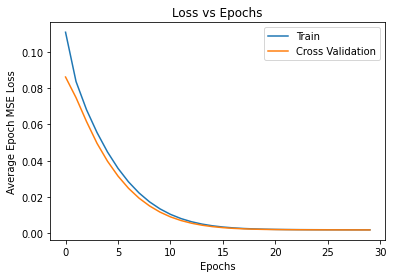

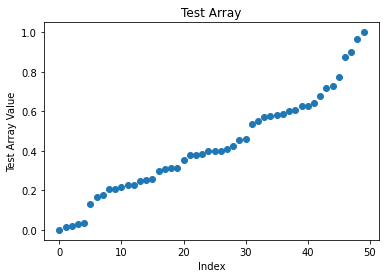

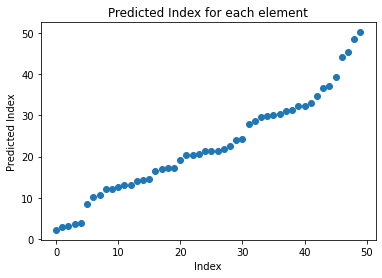

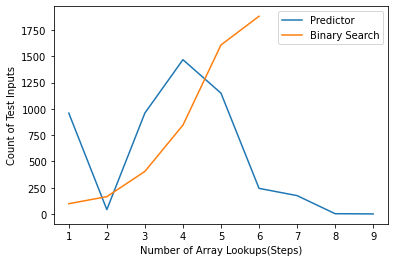

Average Number of Steps
Through Predictor:3.6516
Through Binary Search:4.8676


In [44]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=30)
test_single_array(net,n,'uniform')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)



  0%|          | 0/20 [00:00<?, ?it/s]

0.1981994055211544


 60%|██████    | 12/20 [00:00<00:00, 55.23it/s]

0.09010213762521743
0.07292499616742135
0.06298442110419274
0.05330309309065342
0.04295127056539059
0.03088279627263546
0.018462757114320993
0.008668225817382335
0.0037273622350767256
0.0024665888166055085
0.0023804929340258242
0.0022977657383307813


100%|██████████| 20/20 [00:00<00:00, 52.92it/s]


0.002167772641405463
0.0020874512149021028
0.0020348525955341755
0.0019911395385861395
0.0019528217613697051
0.001919720380101353
0.001891144982073456


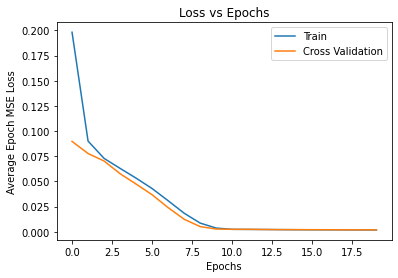

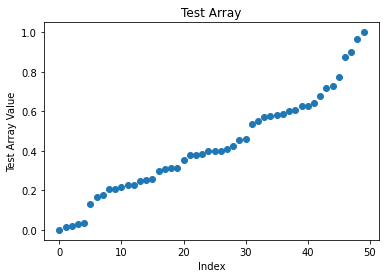

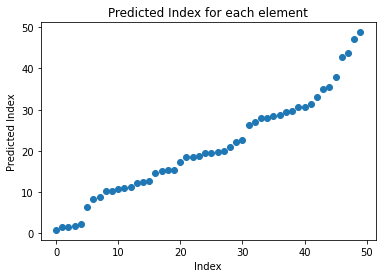

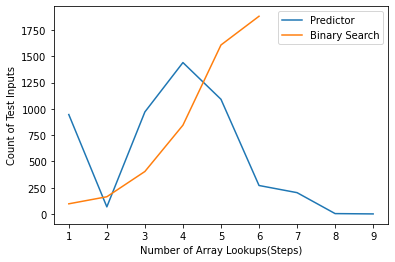

Average Number of Steps
Through Predictor:3.666
Through Binary Search:4.8676


In [45]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=20)
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_input,out=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Normal


 18%|█▊        | 9/50 [00:00<00:00, 85.39it/s]

0.09899216443300247
0.07196348011493683
0.06255588270723819
0.05450064241886139
0.047532955557107924
0.041241996735334394
0.03558823987841606
0.030587026663124562
0.026213360764086247
0.02243546675890684
0.019216021150350572
0.016506534069776535
0.014258722215890885
0.012412021029740572
0.010898667294532061
0.009668011497706176
0.008680140413343907
0.007895166985690594

 54%|█████▍    | 27/50 [00:00<00:00, 83.11it/s]


0.007275940338149667
0.006792463036254049
0.006418361375108361
0.0061310982331633564
0.005912398034706712
0.005746961943805218
0.005622605374082923
0.00552953165024519
0.0054600770119577645
0.005408268794417382
0.0053695420734584335
0.005340430559590459
0.005318346386775375
0.005301371030509472
0.005288103176280856
0.005277526704594493
0.005268914578482509


100%|██████████| 50/50 [00:00<00:00, 81.63it/s]

0.00526174963451922
0.005255668563768268
0.005250416789203882
0.005245818290859461
0.0052417527418583635
0.005238137021660805
0.005234915716573596
0.005232053250074387
0.005229528015479446
0.00522732799872756
0.005225450731813908
0.005223900079727173
0.005222685821354389
0.0052218219265341755
0.0052213279996067286


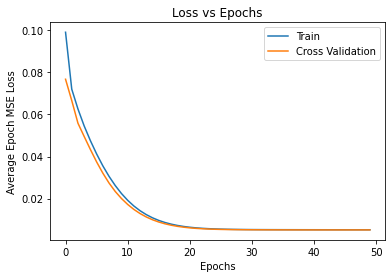

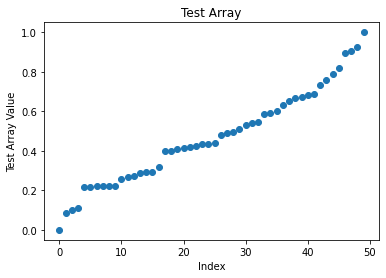

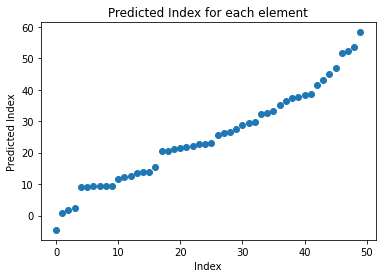

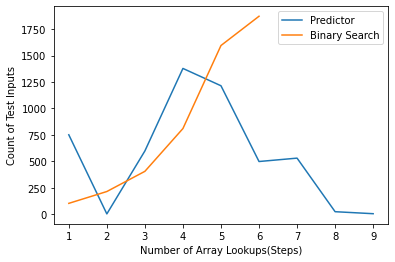

Average Number of Steps
Through Predictor:4.2116
Through Binary Search:4.8406


In [46]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

 26%|██▌       | 13/50 [00:00<00:00, 60.00it/s]

0.12984068393707277
0.08415090665221214
0.07256845831871032
0.06482466198503971
0.055829012766480446
0.044591504707932474
0.031142528168857098
0.017972590029239656
0.009070879267528652
0.00564607409760356
0.004782463703304529
0.004285195376724005
0.0040141096571460365


 50%|█████     | 25/50 [00:00<00:00, 56.68it/s]

0.0038602100452408195
0.0037514641880989075
0.0036732876440510156
0.0036107257008552553
0.0035550315165892243
0.0035052863880991937
0.0034600785933434964
0.0034183161333203316
0.003375295293517411
0.0033252886962145565
0.0032609728630632164
0.003187914798036218


 74%|███████▍  | 37/50 [00:00<00:00, 57.05it/s]

0.0031259042443707585
0.0030743422685191035
0.0030191168654710053
0.0029670311603695156
0.0029148754198104142
0.0028667037142440675
0.002822383982129395
0.002785637602210045
0.00276070109102875
0.002739142091013491
0.002705531497485936
0.0026623561047017575


 98%|█████████▊| 49/50 [00:00<00:00, 56.46it/s]

0.0026200094958767294
0.0025795570109039545
0.0025391267612576486
0.002500942163169384
0.002468710276298225
0.002445571101270616
0.002429336216300726
0.0024098133202642203
0.0023907772731035946
0.002365421340800822
0.002337743923999369
0.0022648570826277136


100%|██████████| 50/50 [00:00<00:00, 56.63it/s]


0.002177301840856671


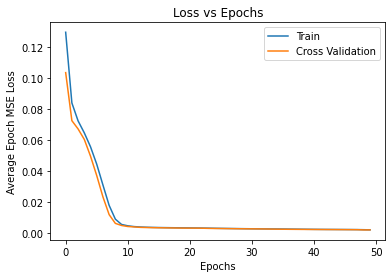

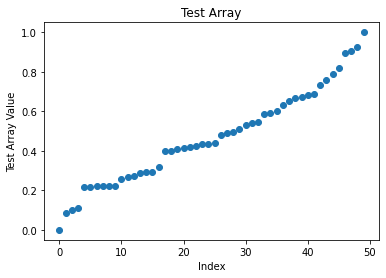

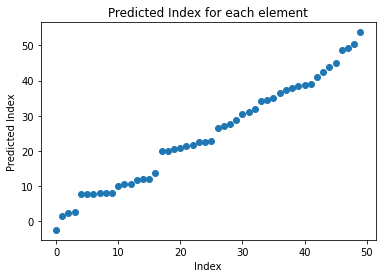

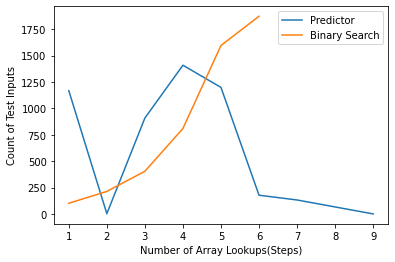

Average Number of Steps
Through Predictor:3.508
Through Binary Search:4.8406


In [47]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_1,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Exponential


  9%|▉         | 9/100 [00:00<00:01, 80.24it/s]

0.08625252172350883
0.0718514509499073
0.061019906774163246
0.052202321216464044
0.04506668113172054
0.039324085041880605
0.034701183810830115
0.030988062918186187
0.028034193255007268
0.025720741786062717
0.023939658515155317
0.02259170524775982
0.021589267440140246
0.020856665819883345
0.020330587401986122
0.019959769770503046


 27%|██▋       | 27/100 [00:00<00:00, 79.59it/s]

0.019702835008502007
0.01952800191938877
0.01941092424094677
0.0193337669596076
0.019283554144203664
0.01925122309476137
0.019230502285063268
0.0192172022536397
0.0192085737362504
0.019202851317822935
0.019198938086628915
0.01919616162776947
0.019194124452769756
0.019192598201334475
0.01919145919382572
0.019190644845366478
0.01919013112783432
0.019189914502203465


 45%|████▌     | 45/100 [00:00<00:00, 83.16it/s]

0.019190002419054508
0.01919041257351637
0.019191158190369605
0.019192253425717353
0.01919370163232088
0.019195494055747987
0.019197601079940795
0.019199970364570617
0.019202523678541184
0.01920515615493059
0.019207741133868694
0.019210142083466053
0.019212226569652557
0.01921387705951929
0.019215002283453943
0.0192155497148633
0.01921549830585718
0.01921485848724842


 64%|██████▍   | 64/100 [00:00<00:00, 85.93it/s]

0.019213664159178735
0.019211962632834912
0.019209809973835944
0.019207265786826612
0.019204390421509742
0.019201247580349447
0.01919790431857109
0.019194431975483893
0.019190907850861548
0.019187416508793832
0.01918404009193182
0.019180857576429844
0.019177932105958462
0.019175305403769015
0.019172991253435613
0.019170975685119628
0.019169227965176106
0.01916770599782467


 82%|████████▏ | 82/100 [00:00<00:00, 83.15it/s]

0.01916637010872364
0.019165189936757088
0.01916414126753807
0.019163207709789278
0.01916237398982048
0.019161623530089857
0.01916094683110714
0.019160334207117557
0.019159776158630848
0.01915926709771156
0.019158799946308137
0.01915837116539478
0.019157977029681205
0.01915761213749647
0.019157274812459945
0.01915696170181036
0.01915667112916708


100%|██████████| 100/100 [00:01<00:00, 81.87it/s]

0.019156400486826895
0.01915614977478981
0.019155915826559067
0.01915569733828306
0.019155493192374706
0.019155303947627544
0.019155127555131914
0.01915496326982975
0.019154810719192027
0.01915466897189617
0.019154538214206696
0.01915441807359457
0.019154307059943677


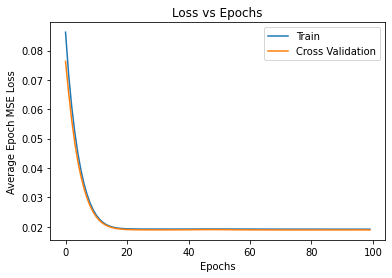

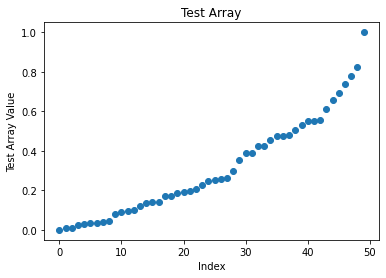

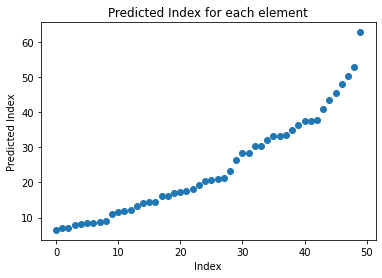

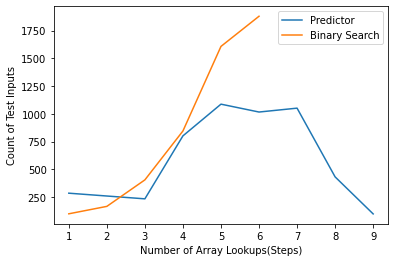

Average Number of Steps
Through Predictor:5.4792
Through Binary Search:4.868


In [48]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=100)
test_single_array(net,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  1%|          | 7/1000 [00:00<00:16, 61.06it/s]

0.10925146117806435
0.07997467666864395
0.06799273043870926
0.05515387170016765
0.04048324562609196
0.026980695314705372
0.020558925718069075
0.019949682429432868
0.019822030887007715
0.019526860490441323
0.019405359402298927
0.01897021885961294
0.018248618952929972


  2%|▏         | 21/1000 [00:00<00:16, 60.52it/s]

0.017774809338152408
0.01735036578029394
0.016887889616191386
0.016360904648900033
0.01574499048292637
0.015039426553994418
0.014238848257809878
0.013343666307628154
0.012362781446427107
0.011327787954360246
0.010290555190294981
0.00929012056440115
0.00833336184732616


  3%|▎         | 34/1000 [00:00<00:16, 58.98it/s]

0.007441770099103451
0.006642981851473451
0.005946496268734336
0.005355755146592855
0.004868008010089397
0.004475955804809928
0.004170847125351429
0.003938096412457526
0.0037681121146306397
0.003641238156706095
0.003543216874822974
0.0034726130310446025


  5%|▍         | 46/1000 [00:00<00:16, 58.15it/s]

0.0034239011583849788
0.0033871396910399197
0.0033546023070812224
0.0033250903943553567
0.003299188893288374
0.0032765321899205445
0.003261051489971578
0.0032497200882062316
0.003240212611854076
0.003235194110311568
0.0032312386902049184
0.0032300503924489023


  6%|▌         | 58/1000 [00:01<00:17, 55.05it/s]

0.0032289767637848853
0.0032279783859848975
0.003226945735514164
0.0032265154412016274
0.00322625027038157
0.003226383565925062
0.003226312040351331
0.0032255078200250863
0.0032245671609416604
0.003223710064776242
0.003222583653405309


  7%|▋         | 70/1000 [00:01<00:16, 55.54it/s]

0.0032214940991252662
0.003220186778344214
0.0032191317062824965
0.0032180842943489553
0.003217744664289057
0.00321755507029593
0.0032171185361221434
0.00321695520542562
0.003217378235422075
0.0032170488964766266
0.0032172974664717914
0.0032175905769690873


  8%|▊         | 82/1000 [00:01<00:16, 56.58it/s]

0.003217670344747603
0.0032176174223423003
0.003217791975475848
0.003218184853903949
0.0032182131661102177
0.0032180216396227477
0.003217482566833496
0.0032168688019737603
0.0032161219976842405
0.0032150993356481194
0.0032140132039785384
0.0032119358191266658


  9%|▉         | 94/1000 [00:01<00:15, 57.05it/s]

0.0032021777704358103
0.003186263842508197
0.003180692857131362
0.0031764479586854576
0.0031730700982734563
0.0031711622374132275
0.003169961040839553
0.0031695357291027905
0.0031694632954895495
0.0031698331702500583
0.003171766735613346
0.0031726917950436473


 11%|█         | 106/1000 [00:01<00:15, 57.80it/s]

0.0031721926294267177
0.003170175990089774
0.0031666835071519016
0.003163934964686632
0.0031618149252608417
0.0031591613311320542
0.0031561809591948986
0.0031529379077255724
0.003151352587155998
0.0031498435884714125
0.003148764045909047
0.0031477181240916253


 12%|█▏        | 118/1000 [00:02<00:15, 56.93it/s]

0.0031452040653675794
0.003141714446246624
0.003140133386477828
0.0031391893047839404
0.0031368052354082466
0.0031348355580121277
0.0031327057629823686
0.0031317604007199407
0.0031317339278757574
0.003131079231388867
0.0031308381352573634
0.0031305657466873527


 13%|█▎        | 131/1000 [00:02<00:14, 58.95it/s]

0.003129104827530682
0.003127475455403328
0.0031267862766981127
0.003125942009501159
0.0031249373685568573
0.0031237052520737053
0.0031230174237862228
0.00312236116733402
0.003121400740928948
0.003120952821336687
0.0031203347723931076
0.0031191431218758224
0.0031174927251413466


 14%|█▍        | 144/1000 [00:02<00:14, 59.95it/s]

0.0031165446853265166
0.003115791454911232
0.0031147397588938476
0.0031141618033871054
0.003113836538977921
0.0031136373290792108
0.0031139347469434143
0.0031139347469434143
0.0031131716212257745
0.003112797113135457
0.0031127695227041842
0.003112675785087049
0.003112056967802346


 16%|█▌        | 156/1000 [00:02<00:14, 58.27it/s]

0.003111012396402657
0.003109384374693036
0.0031082745874300597
0.0031076962593942882
0.003106748848222196
0.003106260788626969
0.003105454542674124
0.0031044209375977517
0.0031045809388160705
0.0031045682029798628
0.003104532160796225
0.0031047014985233546


 17%|█▋        | 169/1000 [00:02<00:14, 58.98it/s]

0.003104931744746864
0.003104858403094113
0.003104596072807908
0.0031042909249663353
0.0031040797010064127
0.0031028009252622724
0.003101999405771494
0.0031014157459139822
0.003100727475248277
0.0031001049326732756
0.0030997677240520716
0.0030999677255749702
0.003100249380804598


 18%|█▊        | 182/1000 [00:03<00:14, 58.23it/s]

0.003100693505257368
0.003100804891437292
0.003100927616469562
0.0031008484540507196
0.0031008261255919935
0.00309990297537297
0.003099338454194367
0.003098717704415321
0.003098495723679662
0.003098350134678185
0.00309791611507535
0.0030977140180766583


 19%|█▉        | 194/1000 [00:03<00:14, 57.55it/s]

0.003097350453026593
0.0030972064239904286
0.0030969952465966346
0.003096838318742812
0.003096714988350868
0.003096353798173368
0.003096084180288017
0.0030958955641835926
0.0030958561459556223
0.003095669043250382
0.003095491579733789
0.003094612341374159


 21%|██        | 207/1000 [00:03<00:13, 59.48it/s]

0.003094305214472115
0.0030941445846110584
0.0030939660500735044
0.0030938827199861406
0.0030938293784856796
0.0030937930569052696
0.00309370681643486
0.003093670168891549
0.0030935905873775483
0.003093597711995244
0.003093444090336561
0.0030931367771700026
0.003093045298010111


 22%|██▏       | 220/1000 [00:03<00:13, 59.58it/s]

0.003092752327211201
0.0030926345381885765
0.0030925630126148462
0.0030926448293030263
0.0030923981918022036
0.0030923439422622322
0.0030921167694032193
0.0030920452205464243
0.003091766987927258
0.003091538092121482
0.003090983210131526
0.00309067377820611
0.003090328141115606


 23%|██▎       | 233/1000 [00:04<00:13, 58.23it/s]

0.003089575539343059
0.003088535857386887
0.003086509625427425
0.0030777784064412116
0.00305099890101701
0.0030356937320902945
0.0030261493986472486
0.003016972984187305
0.0030085267964750527
0.0030005496926605703
0.0029932976700365542
0.002988326968625188


 24%|██▍       | 245/1000 [00:04<00:13, 55.83it/s]

0.0029853338375687597
0.002982946764677763
0.002980622719042003
0.0029779978329315783
0.0029752306640148164
0.002972501260228455
0.0029697423335164784
0.00296617413405329
0.002961182314902544
0.0029572751140221954
0.002953797369264066


 26%|██▌       | 258/1000 [00:04<00:12, 57.97it/s]

0.0029491074848920105
0.0029446364846080542
0.002940258150920272
0.0029357254039496183
0.0029322730377316477
0.002929076668806374
0.0029245030134916307
0.002919733477756381
0.002915121801197529
0.002910489309579134
0.0029049731558188794
0.002899823151528835
0.0028957417234778404
0.0028913311660289766


 27%|██▋       | 270/1000 [00:04<00:12, 58.40it/s]

0.0028869309462606907
0.00288401423022151
0.002881338098086417
0.002877084445208311
0.0028715140419080854
0.0028673326130956413
0.002862179698422551
0.0028547763358801603
0.0028477776097133754
0.002841618098318577
0.002834843751043081
0.002828512364067137


 28%|██▊       | 282/1000 [00:04<00:12, 58.07it/s]

0.0028201212408021092
0.002811266528442502
0.0028018105309456586
0.0027919327607378364
0.0027820827439427377
0.0027717655058950184
0.0027617345796898006
0.0027531174244359137
0.002746031596325338
0.00273946956731379
0.0027349986834451557
0.0027314362581819297


 29%|██▉       | 294/1000 [00:05<00:12, 56.67it/s]

0.002727329428307712
0.0027228230610489845
0.0027189538581296802
0.0027155714808031915
0.0027122747153043745
0.0027086297050118446
0.0027053831843659283
0.002702772500924766
0.0026998644694685935
0.0026973493630066516
0.002694857004098594
0.0026930061401799323


 31%|███       | 307/1000 [00:05<00:11, 58.24it/s]

0.002691670507192612
0.0026905526407063006
0.0026899043703451754
0.0026894753566011785
0.002689885930158198
0.0026905097998678683
0.0026924748439341784
0.0026930060004815458
0.0026949891820549966
0.00269806117285043
0.00269965915940702
0.002700324775651097


 32%|███▏      | 320/1000 [00:05<00:11, 58.56it/s]

0.002697692858055234
0.0026947532314807177
0.0026915087597444653
0.0026903651654720307
0.002688557864166796
0.002687015593983233
0.002685985923744738
0.002685430576093495
0.0026844827458262443
0.002684275107458234
0.0026829555397853257
0.0026809381786733867
0.00267989810090512


 33%|███▎      | 332/1000 [00:05<00:11, 58.17it/s]

0.0026791816111654044
0.0026773015037178994
0.0026746224844828247
0.002670951117761433
0.002669992041774094
0.0026698575587943197
0.0026686005294322968
0.0026680410606786608
0.002667530789040029
0.0026639870135113596
0.0026598517550155522
0.0026571444468572736


 34%|███▍      | 344/1000 [00:05<00:11, 57.94it/s]

0.0026556490221992133
0.0026565533597022297
0.0026591331232339145
0.0026594389928504825
0.00265779085457325
0.002654281887225807
0.0026507509406656026
0.0026491925353184344
0.002648306265473366
0.002647673198953271
0.002645527315326035
0.0026443224167451264


 36%|███▌      | 356/1000 [00:06<00:11, 56.15it/s]

0.002643154188990593
0.002641801768913865
0.002639579609967768
0.002637969935312867
0.002637839037925005
0.0026370296953246
0.0026361218886449935
0.002635845844633877
0.002635893877595663
0.0026356474496424197
0.0026349055813625457
0.00263303816318512


 36%|███▌      | 362/1000 [00:06<00:11, 55.14it/s]

0.002630839846096933
0.0026292889611795544
0.0026277010329067707
0.0026256612967699767
0.0026232210220769048
0.002622535591945052
0.0026226540561765433
0.0026232976699247955
0.0026245244778692724
0.0026235904078930616
0.0026205885224044323
0.002618204103782773


 38%|███▊      | 375/1000 [00:06<00:10, 57.25it/s]

0.0026159069268032907
0.002615270693786442
0.0026144744828343392
0.002615247992798686
0.002615536726079881
0.0026146256597712634
0.0026133019709959626
0.002611362957395613
0.0026095414534211157
0.002609185082837939
0.002608827501535416
0.002607065881602466


 39%|███▊      | 387/1000 [00:06<00:11, 55.72it/s]

0.002605159510858357
0.0026033830363303423
0.0026019092183560133
0.0026007866486907004
0.0025999890640378
0.0025984890293329955
0.0025985305896028877
0.0025984609965234995
0.0025984979001805186
0.0025968882255256176
0.002594024734571576


 40%|███▉      | 399/1000 [00:06<00:10, 55.67it/s]

0.002592482091858983
0.00259147216565907
0.0025915073463693263
0.0025915206875652074
0.002591011906042695
0.0025897294515743853
0.0025895644212141633
0.002590161608532071
0.002591025340370834
0.0025913578225299715
0.002589194104075432
0.0025879191467538475


 41%|████      | 411/1000 [00:07<00:10, 54.50it/s]

0.0025860173627734184
0.0025846270844340326
0.0025823333533480765
0.0025812922744080425
0.0025814712746068834
0.0025811393512412905
0.002581284544430673
0.0025811037747189404
0.002579688862897456
0.0025785756995901467
0.0025768975261598825


 42%|████▏     | 424/1000 [00:07<00:10, 56.41it/s]

0.0025747981388121845
0.002573878224939108
0.0025738372700288893
0.0025737745221704245
0.002573021501302719
0.0025724752573296427
0.0025728091830387713
0.002572012972086668
0.002569482964463532
0.0025677178986370564
0.0025661387713626026
0.0025657338090240957
0.002566213323734701
0.002567601390182972


 44%|████▎     | 436/1000 [00:07<00:09, 57.18it/s]

0.0025689684320241214
0.002568898140452802
0.002567621017806232
0.0025659918319433928
0.0025648665614426136
0.002563868369907141
0.0025623975321650504
0.002561165136285126
0.002559799421578646
0.002559297694824636
0.0025588281219825148
0.0025581388734281065


 45%|████▍     | 448/1000 [00:07<00:09, 56.32it/s]

0.0025571152102202175
0.002556774369440973
0.00255691553466022
0.002556621003895998
0.002557470090687275
0.0025580787099897862
0.002557964459992945
0.0025566185591742395
0.002554458240047097
0.002552279573865235
0.002550906105898321
0.0025498308939859273


 46%|████▌     | 460/1000 [00:08<00:09, 56.10it/s]

0.002551905205473304
0.0025551357306540013
0.00255772965028882
0.0025575279956683516
0.0025538785848766565
0.002550044422969222
0.002547579747624695
0.0025464231846854092
0.0025470647029578685
0.00254864280577749
0.002550524123944342
0.0025517150992527605


 47%|████▋     | 472/1000 [00:08<00:09, 55.42it/s]

0.0025525034172460435
0.0025520842289552094
0.0025500312214717267
0.0025477260584011673
0.0025449092499911785
0.002543295454233885
0.002543898904696107
0.002544237463735044
0.0025448634754866362
0.002546192775480449
0.0025489026913419364
0.0025502983713522553


 48%|████▊     | 485/1000 [00:08<00:09, 57.09it/s]

0.002549559669569135
0.002545445179566741
0.0025408271932974456
0.002538606896996498
0.002538590133190155
0.0025390540948137643
0.0025404247222468256
0.0025426690233871342
0.0025436504278331996
0.0025446033803746106
0.002544207684695721
0.0025435805320739744


 50%|████▉     | 497/1000 [00:08<00:08, 57.25it/s]

0.002543288143351674
0.002543621580116451
0.0025425665080547333
0.0025401189224794505
0.002538047218695283
0.002537655783817172
0.0025378370890393855
0.0025388125330209734
0.0025390742346644403
0.0025393509306013582
0.002539472095668316
0.0025394127937033773


 51%|█████     | 509/1000 [00:08<00:08, 57.04it/s]

0.0025392901618033646
0.00253757166210562
0.0025362479267641903
0.0025351523188874127
0.0025349368108436464
0.002534122532233596
0.0025338289327919484
0.0025348597671836616
0.002535638678818941
0.0025353968841955064
0.0025349492440000176
0.002534646634012461


 52%|█████▏    | 521/1000 [00:09<00:08, 56.98it/s]

0.0025343850953504442
0.002535078837536275
0.0025358865736052395
0.0025354452198371293
0.0025345539674162866
0.0025338532635942102
0.0025329004041850568
0.002530867978930473
0.0025301025249063968
0.002530430699698627
0.0025304814800620077


 53%|█████▎    | 533/1000 [00:09<00:08, 54.35it/s]

0.0025300386594608428
0.0025299880420789123
0.0025296178180724384
0.0025294560473412275
0.002529072226025164
0.0025293358135968446
0.002529248408973217
0.0025294240796938537
0.0025291974190622566
0.0025291931815445423
0.0025290733901783824
0.0025288679637014864


 55%|█████▍    | 546/1000 [00:09<00:08, 56.15it/s]

0.00252796346321702
0.0025273025035858153
0.0025264725089073183
0.00252603639382869
0.002525911433622241
0.002526292530819774
0.0025269292062148454
0.0025272884173318743
0.002527361153624952
0.0025271886494010686
0.0025263364193961026
0.0025241409428417684


 56%|█████▌    | 558/1000 [00:09<00:07, 56.76it/s]

0.002523009036667645
0.0025227612815797327
0.002522674249485135
0.0025232137413695455
0.0025236549321562053
0.0025239443173632027
0.002524263481609523
0.002524294424802065
0.0025242035742849113
0.0025242167757824063
0.0025241841562092305
0.002523854305036366


 57%|█████▋    | 571/1000 [00:10<00:07, 57.73it/s]

0.0025232745800167324
0.002522171335294843
0.00252067893743515
0.002519749663770199
0.002519062696956098
0.002519139414653182
0.002519015735015273
0.002519693342037499
0.0025198498275130986
0.002520330622792244
0.0025206627789884804
0.00252030617557466


 58%|█████▊    | 583/1000 [00:10<00:07, 55.93it/s]

0.002520933304913342
0.0025214114459231494
0.0025208866456523536
0.0025200024945661427
0.0025186964543536306
0.002517417375929654
0.0025166389299556614
0.0025167017010971904
0.002517109923064709
0.0025187817402184008
0.002519436599686742
0.0025185653939843178


 60%|█████▉    | 596/1000 [00:10<00:07, 57.65it/s]

0.002517309901304543
0.002516013616696
0.0025140449637547136
0.0025132164824754
0.0025133253540843723
0.002515000500716269
0.002517411415465176
0.0025194135261699556
0.0025189728708937763
0.0025166273815557362
0.0025148427346721293
0.002513110265135765
0.002511791721917689


 61%|██████    | 608/1000 [00:10<00:06, 56.80it/s]

0.00251133400015533
0.002512046042829752
0.0025142321130260823
0.002516089542768896
0.002516925660893321
0.002516730362549424
0.002515179989859462
0.0025128793669864534
0.0025119652738794683
0.0025118077639490364
0.002512261178344488
0.0025127229979261755


 62%|██████▏   | 620/1000 [00:10<00:06, 56.32it/s]

0.002513306913897395
0.002512889844365418
0.0025131998118013144
0.002512597944587469
0.0025115904165431855
0.0025109055684879424
0.002509882324375212
0.002508569788187742
0.002508391719311476
0.0025095241144299507
0.002511382568627596
0.0025133016053587197


 63%|██████▎   | 632/1000 [00:11<00:06, 56.79it/s]

0.0025136089418083428
0.0025126514956355095
0.002510934043675661
0.002509572310373187
0.0025086554698646067
0.002508668787777424
0.0025091593153774737
0.002509708306752145
0.002510258904658258
0.002510365564376116
0.00250999687705189
0.002509202901273966


 64%|██████▍   | 644/1000 [00:11<00:06, 56.27it/s]

0.0025079303188249467
0.0025068909861147405
0.002506829076446593
0.0025065798545256257
0.0025078957201913
0.00250882925465703
0.002509540505707264
0.0025096770841628313
0.0025093004340305926
0.0025086598470807076
0.0025074359960854053
0.002507015853188932


 66%|██████▌   | 657/1000 [00:11<00:05, 57.90it/s]

0.002506226720288396
0.002506142668426037
0.0025058923522010444
0.0025056379847228525
0.002505811536684632
0.0025061926804482936
0.002506133308634162
0.0025061697466298937
0.002505954960361123
0.0025058815954253078
0.002504715183749795
0.0025044143898412586
0.0025037032552063464


 67%|██████▋   | 669/1000 [00:11<00:05, 56.84it/s]

0.0025031960569322107
0.0025037528481334447
0.002503527398221195
0.002504477649927139
0.002503630891442299
0.0025047445204108955
0.002504233387298882
0.0025042932014912368
0.0025035622296854854
0.002502896427176893
0.0025024154223501683
0.0025024420348927377


 68%|██████▊   | 681/1000 [00:11<00:05, 56.96it/s]

0.00250256669241935
0.002502732095308602
0.0025027938187122344
0.002502750325948
0.0025027819676324723
0.002503214683383703
0.0025035044876858593
0.002503113751299679
0.002502838778309524
0.002502593630924821
0.0025022030575200917
0.002501790737733245


 69%|██████▉   | 693/1000 [00:12<00:05, 57.79it/s]

0.0025008340831846
0.0024999419692903757
0.0024997785687446593
0.0025000448804348707
0.002500291704200208
0.002500922232866287
0.002501304796896875
0.0025014543905854227
0.0025010660756379366
0.002500638994388282
0.0025004400173202156
0.00249996033962816


 70%|██████▉   | 699/1000 [00:12<00:05, 55.30it/s]

0.0024995762621983887
0.0024998891167342663
0.0024993980303406717
0.002498437790200114
0.0024987480603158472
0.002498329570516944
0.002498136111535132
0.0024986062897369267
0.0024986189091578126
0.0024985915515571833
0.00249841776676476
0.002498845895752311


 72%|███████▏  | 718/1000 [00:12<00:04, 57.99it/s]

0.0024993852945044636
0.0024998549604788424
0.002500025928020477
0.002500269445590675
0.0024982299422845245
0.0024981361581012606
0.0024968963349238037
0.0024966777535155417
0.002496736613102257
0.0024977406952530145
0.0024990636156871915
0.002499617263674736
0.0024992035701870917


 73%|███████▎  | 730/1000 [00:12<00:04, 57.99it/s]

0.0024988767225295307
0.002498189872130752
0.0024967276491224765
0.0024960291106253863
0.002495551691390574
0.0024953366722911597
0.0024954534834250807
0.002496183500625193
0.002497118734754622
0.002498163841664791
0.002497910032980144
0.002497455291450024


 74%|███████▍  | 742/1000 [00:13<00:04, 58.12it/s]

0.002496588509529829
0.002496606530621648
0.00249531336594373
0.0024958525551483034
0.0024950916646048426
0.00249572794418782
0.0024954962776973844
0.0024962629191577434
0.002494862931780517
0.0024947037221863867
0.0024948234902694823
0.0024962173774838448


 75%|███████▌  | 754/1000 [00:13<00:04, 57.14it/s]

0.0024968589656054973
0.0024965817807242273
0.002495659654960036
0.0024950909428298473
0.0024949423037469386
0.0024945955723524094
0.002494949521496892
0.002494734525680542
0.002494387840852141
0.002494306582957506
0.0024942624382674693
0.002494408981874585


 77%|███████▋  | 766/1000 [00:13<00:04, 56.70it/s]

0.002494232542812824
0.0024944288656115533
0.0024945275858044625
0.0024942326359450816
0.0024945487501099707
0.0024941478855907916
0.0024942029966041447
0.002493933355435729
0.002493116073310375
0.0024930830346420406
0.002493101661093533
0.0024932443629950285


 78%|███████▊  | 778/1000 [00:13<00:03, 56.60it/s]

0.0024934173794463276
0.002493469137698412
0.002493540639989078
0.0024936053203418853
0.0024938366608694197
0.002493918361142278
0.002493708557449281
0.002493492071516812
0.002493083383888006
0.002492950344458222
0.00249275213573128
0.0024921470088884235


 79%|███████▉  | 790/1000 [00:13<00:03, 55.59it/s]

0.0024916387628763914
0.0024914446752518416
0.0024918704992160203
0.0024923737859353424
0.0024925286648795008
0.0024924590019509197
0.0024929176550358536
0.002492443355731666
0.0024919323157519104
0.0024915374116972087
0.0024911576183512807
0.002490703552030027


 80%|████████  | 802/1000 [00:14<00:03, 56.18it/s]

0.0024905983125790955
0.0024903775891289117
0.00248999607283622
0.0024900627555325626
0.002490971819497645
0.0024916410446166994
0.002492491784505546
0.002492621913552284
0.002491788938641548
0.002490978012792766
0.0024903908604756
0.0024899365147575737


 81%|████████▏ | 814/1000 [00:14<00:03, 55.42it/s]

0.0024895059643313287
0.0024893042165786026
0.002489279257133603
0.0024891102453693747
0.002489481819793582
0.002489794627763331
0.002489979052916169
0.002490298333577812
0.0024906961945816873
0.0024910742416977883
0.002490902179852128
0.0024907193845137955


 83%|████████▎ | 826/1000 [00:14<00:03, 55.50it/s]

0.00248969248495996
0.002488730871118605
0.002488284301944077
0.0024884229991585017
0.002488590031862259
0.002489298628643155
0.0024904574267566202
0.0024916047230362894
0.002491897018626332
0.002490301453508437
0.0024893559515476228
0.002488549309782684


 84%|████████▍ | 838/1000 [00:14<00:02, 55.64it/s]

0.002488230844028294
0.0024880787124857305
0.0024879570119082928
0.002488095290027559
0.0024884056299924852
0.0024884992744773626
0.002489055530168116
0.0024892807239666583
0.0024890828877687453
0.002488835505209863
0.0024882813217118383
0.0024876702576875688


 85%|████████▌ | 850/1000 [00:14<00:02, 55.83it/s]

0.002487481408752501
0.0024871404515579344
0.0024872152134776115
0.0024875149363651873
0.0024877804331481456
0.0024880905635654925
0.0024882934289053083
0.0024877728195860983
0.0024876631563529373
0.0024873801972717046
0.0024871766567230225
0.002486250805668533


 86%|████████▌ | 862/1000 [00:15<00:02, 55.89it/s]

0.00248644407838583
0.002486269688233733
0.002486188570037484
0.0024865367682650684
0.002486528968438506
0.002486607083119452
0.002487242897041142
0.0024870980763807894
0.002486844058148563
0.0024867276661098003
0.002486447896808386
0.0024860818171873688


 87%|████████▋ | 868/1000 [00:15<00:02, 53.02it/s]

0.002486136322841048
0.0024863948579877614
0.0024862681981176137
0.0024861157406121494
0.0024861770682036875
0.0024858068209141493
0.002486232062801719
0.0024864794220775368
0.002486344403587282
0.002486180001869798
0.0024858616525307298


 88%|████████▊ | 880/1000 [00:15<00:02, 55.19it/s]

0.0024858083575963973
0.0024850619724020363
0.002484305901452899
0.002484380407258868
0.0024844076251611114
0.0024850055575370788
0.0024859347147867085
0.002486250805668533
0.0024865317158401013
0.002486294973641634
0.002485412359237671
0.0024847565218806267


 89%|████████▉ | 892/1000 [00:15<00:01, 56.98it/s]

0.0024840405443683268
0.0024834806798025967
0.0024833161616697906
0.002483076509088278
0.0024834679439663886
0.002483388362452388
0.00248409912455827
0.0024845147505402564
0.002484541549347341
0.002484283992089331
0.002484113723039627
0.0024840694619342684


 90%|█████████ | 904/1000 [00:15<00:01, 56.62it/s]

0.002483771974220872
0.002483522775582969
0.0024834902258589866
0.0024830135283991695
0.002483284310437739
0.002483568782918155
0.0024831226095557214
0.002484041824936867
0.0024837999138981105
0.0024845909094437955
0.002484013349749148
0.0024838792625814675


 92%|█████████▏| 916/1000 [00:16<00:01, 56.22it/s]

0.0024833583971485495
0.0024823211599141358
0.0024824065156280996
0.002481867512688041
0.0024830670561641456
0.002483531925827265
0.0024839424062520266
0.0024835224729031326
0.002482554782181978
0.0024813453666865824
0.00248102773912251
0.0024813898373395203


 93%|█████████▎| 928/1000 [00:16<00:01, 55.26it/s]

0.002481752634048462
0.0024818591075018047
0.002482651616446674
0.0024834386538714172
0.00248363777063787
0.002483458397909999
0.002483211806975305
0.0024827411398291588
0.0024820099817588924
0.0024812715128064156
0.0024815741926431656
0.002481915056705475


 94%|█████████▍| 940/1000 [00:16<00:01, 56.38it/s]

0.00248215370811522
0.0024825962726026775
0.002482799137942493
0.0024830711307004096
0.0024832661263644697
0.002483294461853802
0.0024828916182741525
0.0024825660046190025
0.002482395409606397
0.0024820819729939104
0.0024816291872411965
0.002481291024014354


 95%|█████████▌| 953/1000 [00:16<00:00, 57.77it/s]

0.002481209486722946
0.0024817071622237562
0.002482280554249883
0.0024820817168802025
0.0024826723616570233
0.0024834277108311655
0.002482995972968638
0.002482301602140069
0.002482027281075716
0.0024818488163873553
0.0024805200286209584
0.002480066753923893


 96%|█████████▋| 965/1000 [00:17<00:00, 57.55it/s]

0.0024806063855066897
0.0024805197725072505
0.0024808184709399937
0.002481754473410547
0.0024824061896651984
0.002482565911486745
0.0024822671199217438
0.0024817420402541757
0.0024809312308207154
0.0024800871266052126
0.0024798661004751922
0.002479534037411213


 98%|█████████▊| 977/1000 [00:17<00:00, 57.31it/s]

0.0024794678436592223
0.0024802572093904018
0.002480852883309126
0.002481290721334517
0.002481692912988365
0.0024817857658490537
0.002481930935755372
0.002481554076075554
0.0024812029674649238
0.002480683568865061
0.0024799910141155125
0.0024801344145089386


 99%|█████████▉| 989/1000 [00:17<00:00, 55.33it/s]

0.002480296837165952
0.002480917074717581
0.0024805598426610232
0.002480728505179286
0.002480215742252767
0.0024807115318253637
0.002480700914748013
0.0024803068954497576
0.002480407035909593
0.002480042283423245
0.002479953062720597


100%|██████████| 1000/1000 [00:17<00:00, 56.66it/s]

0.0024805473396554588
0.002480812929570675
0.002481001685373485
0.002480953512713313
0.0024810015922412275
0.002480934443883598
0.0024806469213217498
0.0024803691077977417


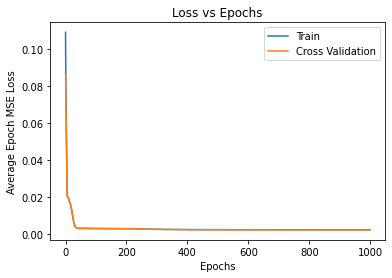

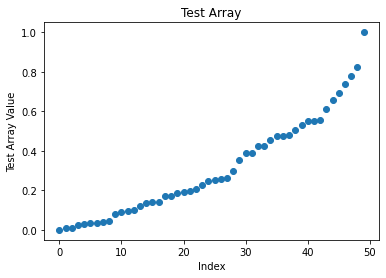

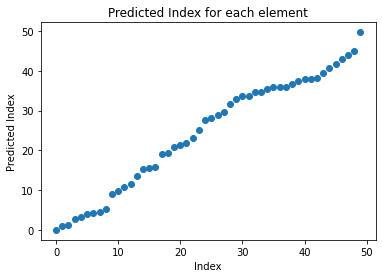

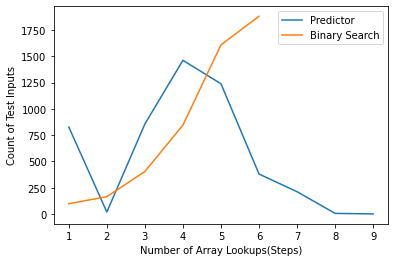

Average Number of Steps
Through Predictor:3.8576
Through Binary Search:4.868


In [49]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=1000)
test_single_array(net_1,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Mixed

  0%|          | 0/50 [00:00<?, ?it/s]

0.09438211023807526
0.06944884210824967


 24%|██▍       | 12/50 [00:00<00:01, 33.98it/s]

0.05592910535633564
0.04596764147281647
0.03776748701930046
0.03133420329540968
0.026234839297831058
0.022155789099633692
0.018944153934717177
0.016453853342682123
0.014556549023836851
0.013137398194521666
0.012094043847173452
0.011339389812201261
0.010802362393587828
0.010425707791000605
0.010164455510675907
0.009984875470399857
0.009861696977168322


 60%|██████    | 30/50 [00:00<00:00, 59.95it/s]

0.009776855446398258
0.009717738255858421
0.00967567777261138
0.009644899051636457
0.009621658828109503
0.009603578317910432
0.009589155018329621
0.00957741802558303
0.00956767974421382
0.009559365082532167
0.009551917668431997
0.009544784761965274
0.009537452552467584
0.009529486205428839
0.009520543459802865
0.00951048731803894
0.009499660693109035
0.009489072859287262
0.009479972068220377


100%|██████████| 50/50 [00:00<00:00, 56.57it/s]

0.00947296228259802
0.009467622824013233
0.009463043510913849
0.009458646364510059
0.009454477857798339
0.009450751170516015
0.009447409678250552
0.009444306697696447
0.00944144669920206
0.009438843373209238
0.009436447825282811
0.00943424878641963


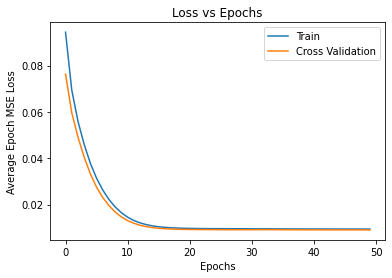

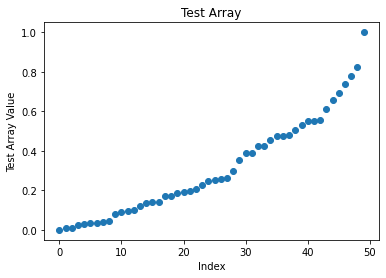

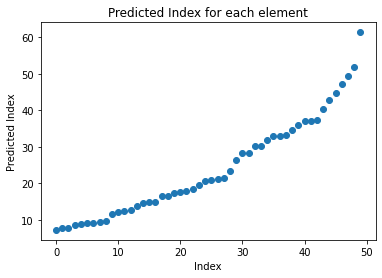

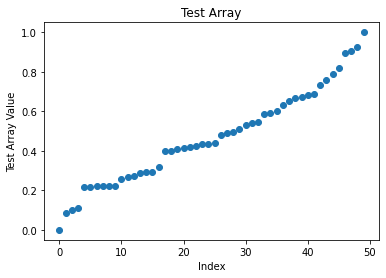

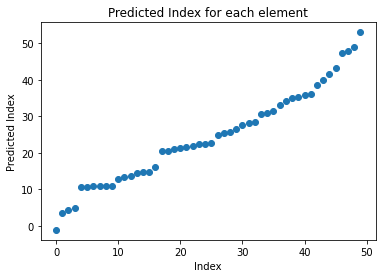

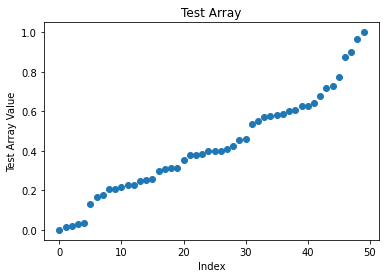

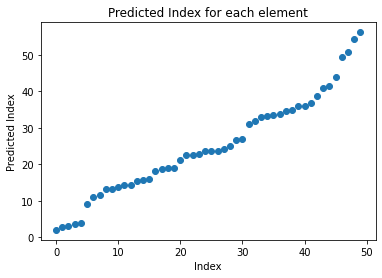

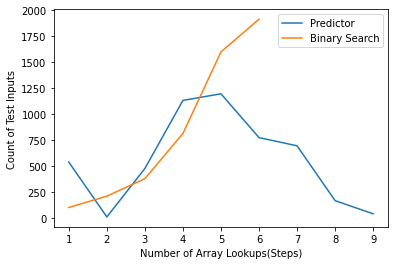

Average Number of Steps
Through Predictor:4.7108
Through Binary Search:4.8692


In [50]:
net=Net_NHL()
net.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net,n,'exponential')
test_single_array(net,n,'normal')
test_single_array(net,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)




 14%|█▍        | 7/50 [00:00<00:00, 60.86it/s]

0.13946643546223642
0.08585509732365608
0.07343574315309524
0.062093048542737964
0.050163283571600915
0.037979424744844434
0.025955956429243088
0.016618095431476833
0.011754103470593691
0.009968296438455582
0.009604571294039488
0.009497269708663224
0.00937650203704834


 40%|████      | 20/50 [00:00<00:00, 58.47it/s]

0.009276834595948458
0.009200151916593314
0.009138303250074387
0.0090861601755023
0.009039268177002669
0.008997742924839259
0.008962259627878666
0.008931509964168072
0.008903825655579567
0.008879152219742536
0.008857612498104572
0.008837791997939349


 64%|██████▍   | 32/50 [00:00<00:00, 57.00it/s]

0.008820493798702955
0.008804843947291374
0.008790863491594792
0.008778487052768468
0.008767370786517858
0.008757424168288707
0.008748857025057077
0.008741600438952446
0.008735362533479929
0.00873060328885913
0.008727966621518136
0.008726860117167234


100%|██████████| 50/50 [00:00<00:00, 57.99it/s]

0.008727111481130123
0.008728826232254506
0.008731849584728479
0.00873614326119423
0.008739606384187937
0.008740130346268415
0.008736331481486559
0.008728293888270854
0.008717300929129123
0.008704578690230846
0.008692361135035753
0.008682174142450094
0.008675313461571932


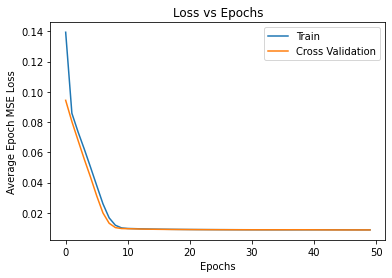

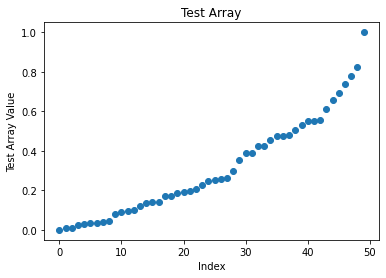

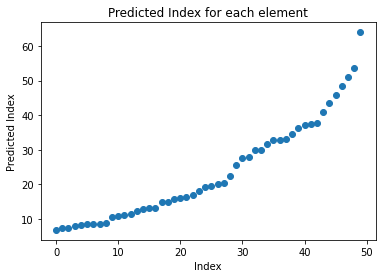

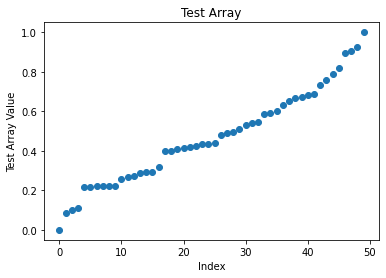

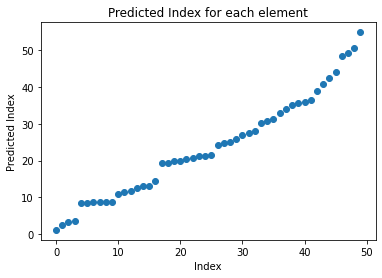

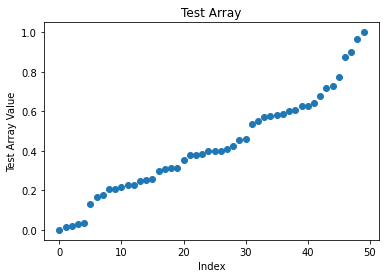

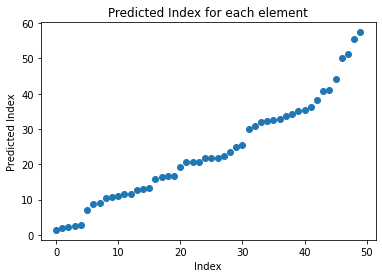

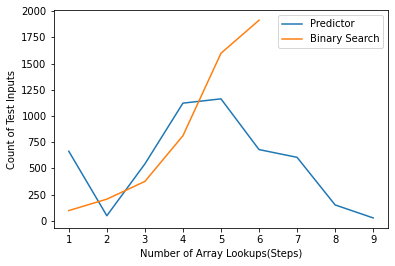

Average Number of Steps
Through Predictor:4.4896
Through Binary Search:4.8692


In [51]:
net_1=Net_1HL()
net_1.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_1,n,'exponential')
test_single_array(net_1,n,'normal')
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)
